# Exercise 2: Variable flux reluctance machine

In [1]:
from vfrm import Driver, Geometry, Machine, Angle, ElectricCurrent, Torque
import nutils.function
import treelog_notebook

In [2]:
driver = Driver(
    peak_ac_current=nutils.function.Argument('Iacpeak', ()) * ElectricCurrent('A'),
    dc_current=nutils.function.Argument('Idc', ()) * ElectricCurrent('A'),
)
machine = Machine(driver=driver)

mesh > gmsh > Running '/usr/local/bin/gmsh /home/9000/vfrm.geo -o /tmp/tmp7yn09inx.msh -order 2 -2 -bin -setnumber r_ri 0.0105 -setnumber h_ry 0.0205 -setnumber h_rt 0.014400000000000001 -setnumber h_a 0.000535 -setnumber h_sea 0.00775 -setnumber h_sed 0.00775 -setnumber h_sca 0.009000000000000001 -setnumber h_scd 0.00775 -setnumber h_s 0.024100000000000003 -setnumber a_rti 0.005 -setnumber a_rto 0.01 -setnumber n_rt 5 -setnumber a_sti 0.013000000000000001 -setnumber n_st 6 -setnumber h_e 0.01 -setnumber n_ea 1 -setnumber m 2 -setnumber f_i 0.5' [Gmsh 4.13.1, 1 node, max. 1 thread]
mesh > gmsh > Started on Sun May 18 01:34:55 2025
mesh > gmsh > Reading '/home/9000/vfrm.geo'...
mesh > gmsh > Done reading '/home/9000/vfrm.geo'
mesh > gmsh > Reconstructing periodicity for curve connection 11 - 1
mesh > gmsh > Reconstructing periodicity for curve connection 12 - 2
mesh > gmsh > Reconstructing periodicity for curve connection 107 - 83
mesh > gmsh > Reconstructing periodicity for curve conne

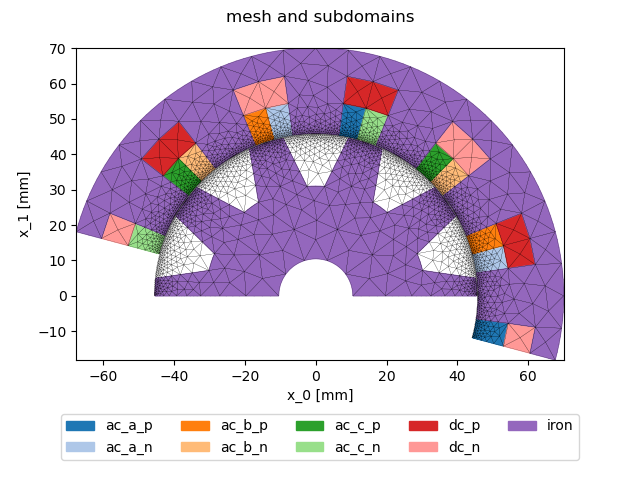

In [3]:
machine.plot_mesh()

In [4]:
args = dict(
    Iacpeak=30, # unit: A
    Idc=20, # unit: A
)
args = machine.solve(arguments=args)

solve > solve > solving for argument A (8,13295) and λ (8,540) using direct method
solve > solve > residual norm: 1.5e-16


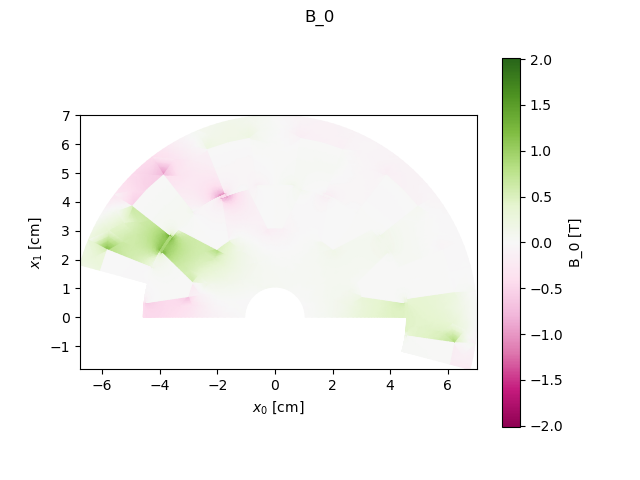

In [5]:
machine.plot_field(
    'B_0', 'T',
    thetam=Angle('0deg'),
    clim='symmetric',
    cmap='PiYG',
    arguments=args,
)

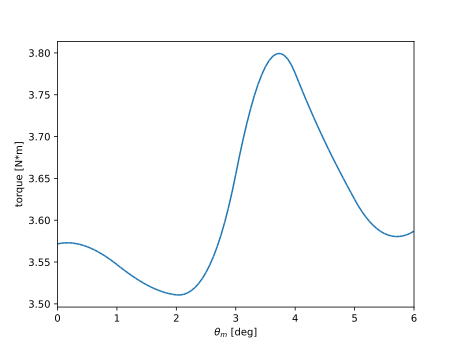

In [6]:
machine.plot_thetam('torque', 'N*m', arguments=args)

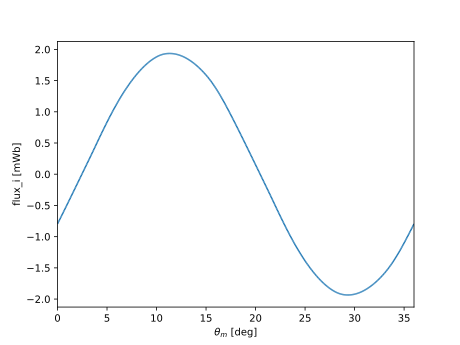

In [7]:
machine.plot_flux(arguments=args)

In [8]:
from nutils_solver_extra import minimize

lambdatorque = nutils.function.Argument('lambdatorque', ()) / Torque('N*m')
fun = ('Pac + Pdc' @ machine.ns) / 'W' \
    + lambdatorque * (machine.ns.avgtorque - Torque('10N*m'))

args = minimize(
    fun,
    'Iacpeak,Idc,lambdatorque',
    machine.residual,
    machine.trials,
    machine.tests,
    constrain=machine.constraints,
    tol=1e-8,
    arguments=args,
)

machine.print_scalar('avgtorque', 'N*m', arguments=args)
machine.print_scalar('Iacpeak', 'A', arguments=args)
machine.print_scalar('Idc', 'A', arguments=args)
machine.print_scalar('Pac', 'W', arguments=args)
machine.print_scalar('Pdc', 'W', arguments=args)
machine.print_scalar('Protor', 'W', arguments=args)

minimize > minimizing for lambdatorque () and for Iacpeak () and Idc () via A (8, 13295) and λ (8, 540)
minimize > iter 0 > scalar = 4.874e+02, norm([grad(scalar), residual]) = 3.025e+01
minimize > iter 1 > scalar = 1.020e+03, norm([grad(scalar), residual]) = 4.729e+01
minimize > iter 2 > scalar = 1.347e+03, norm([grad(scalar), residual]) = 4.445e+00
minimize > iter 3 > scalar = 1.346e+03, norm([grad(scalar), residual]) = 2.452e-01
minimize > iter 4 > scalar = 1.346e+03, norm([grad(scalar), residual]) = 1.560e-03
minimize > iter 5 > scalar = 1.346e+03, norm([grad(scalar), residual]) = 4.260e-08
minimize > iter 6 > scalar = 1.346e+03, norm([grad(scalar), residual]) = 5.769e-13
avgtorque: 10.000N*m
Iacpeak: 52.698A
Idc: 31.494A
Pac: 1198.069W
Pdc: 148.268W
Protor: 1047.198W
